In [1]:
from model import ClassifierLN5, CustomClassifier

import torch 
from torchvision.datasets import CIFAR10 as CIFARDataset
from torchvision.datasets import MNIST as MNISTDataset
from torchvision.datasets import FashionMNIST as FashMNISTDataset
from torch.cuda import is_available as check_device_availability
from torch import device as Arch
from torch.utils.tensorboard import SummaryWriter as Logger
from torch import set_grad_enabled as disable_backprop
from torch import tensor as Tensor
from torch import norm as Norm
from torch import max as Max
from torch import save as Saver
from torchvision.transforms import Compose as BuildTransform
from torchvision.transforms import Resize as Rescale
from torchvision.transforms import ToTensor as ConvertToTensor
from torchvision.transforms import Normalize as AdjustNormal
from torch.utils.data import random_split as SplitRandomly
from torch.utils.data import DataLoader as DataGenerator
from torch.nn import CrossEntropyLoss as CELoss
from torch.optim import Adam as AdamOptimizer
from torch.optim import RMSprop as RMSOptimizer
from torch.optim import SGD as SGDOptimizer
from torch.utils.data import ConcatDataset as MergeDatasets

from os.path import join as pjoin
from os import makedirs as createdirectories
import numpy as np
import json

from copy import deepcopy as Copier
from tqdm import tqdm
from PIL.ImageOps import invert as ReversePixels

from utils import configuration

In [9]:
class Reverse(object):
    def __init__(self):
        pass
    def __call__(self, x):
        H,W = x.size[:2]
        x = ReversePixels(x)
        return x

In [3]:
from train import train

In [194]:
mnists_transform = BuildTransform([
    Rescale((28,28)),
    ConvertToTensor(),
#     AdjustNormal(mean=[0.1307],
#     std=[0.3081])
])
mnist_pos_inv_trans = BuildTransform([
    AdjustNormal(mean=[-0.1307/0.3081],
                std=[1/0.3081])
])
mnists_neg_transform = BuildTransform([
    Rescale((28,28)),
    Reverse(),
    ConvertToTensor(),
#     AdjustNormal(mean=[0.8691],
#     std=[0.3018])
])
mnist_neg_inv_trans = BuildTransform([
    AdjustNormal(mean=[-0.8691/0.3018],
                std=[1/0.3018])
])

In [195]:
mnist_train_dataset = MNISTDataset(download=True, root='data/mnist', train=True, transform=mnists_transform)
mnist_test_dataset = MNISTDataset(download=True, root='data/mnist', train=False, transform=mnists_transform)

mnist_neg_train_dataset = MNISTDataset(download=True, root='data/mnist', train=True, transform=mnists_neg_transform)
mnist_neg_test_dataset = MNISTDataset(download=True, root='data/mnist', train=False, transform=mnists_neg_transform)

In [19]:
loader = torch.utils.data.DataLoader(mnist_neg_train_dataset,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False)

mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

In [46]:
import random
def show_samples():
    train_ch = random.sample(range(0, len(mnist_train_dataset)), 10)
    neg_train_ch = random.sample(range(0, len(mnist_neg_train_dataset)), 10)
    
    test_ch = random.sample(range(0, len(mnist_test_dataset)), 10)
    f, ax = plt.subplots(4,10)
    for i in range(10):
        ax[0,i].imshow(mnist_train_dataset[train_ch[i]][0][0].cpu().numpy())
        ax[1,i].imshow(mnist_neg_train_dataset[neg_train_ch[i]][0][0].cpu().numpy())
        ax[2,i].imshow(mnist_test_dataset[test_ch[i]][0][0].cpu().numpy())
        ax[3,i].imshow(mnist_neg_test_dataset[test_ch[i]][0][0].cpu().numpy())
    plt.savefig('samples.png')

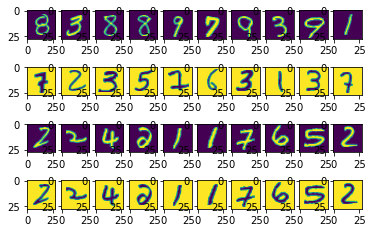

In [47]:
show_samples()

In [99]:
def compute_stats():
    nb_bins = 256
    count = np.zeros(nb_bins)
    print(len(mnist_train_dataset), len(mnist_test_dataset), len(mnist_neg_train_dataset), len(mnist_neg_test_dataset))
    for idx in range(len(mnist_train_dataset)):    
        x = mnist_pos_inv_trans(mnist_train_dataset[idx][0])*255
        x[x<1e-5]=0
        hist = np.histogram(x[0], bins=nb_bins, range=[0, 255])
#         print(hist)
        count += hist[0]
    
    for idx in range(len(mnist_test_dataset)):    
        x = mnist_pos_inv_trans(mnist_test_dataset[idx][0])*255
        x[x<1e-5]=0
        hist = np.histogram(x[0], bins=nb_bins, range=[0, 255])
#         print(hist)
        count += hist[0]
    bins = hist[1]
    fig = plt.figure()
    plt.bar(bins[:-1], count)
    plt.title('Positive MNIST Histogram')
    plt.savefig('positive_stats.png')
    
    neg_count = np.zeros(nb_bins)
    for idx in range(len(mnist_neg_train_dataset)):    
        x = mnist_neg_inv_trans(mnist_neg_train_dataset[idx][0])*255
        x[x<1e-5]=0
        hist = np.histogram(x[0], bins=nb_bins, range=[0, 255])
#         print(hist)
        neg_count += hist[0]
    
    for idx in range(len(mnist_neg_test_dataset)):    
        x = mnist_neg_inv_trans(mnist_neg_test_dataset[idx][0])*255
#         print(x)
#         break
        x[x<1e-5]=0
        hist = np.histogram(x[0], bins=nb_bins, range=[0, 255])
#         print(hist)
        neg_count += hist[0]
        
    bins = hist[1]
    plt.figure()
    plt.bar(bins[:-1], neg_count)
    plt.title('Negative MNIST Histogram')
    plt.savefig('negative_stats.png')
    return count, neg_count

60000 10000 60000 10000


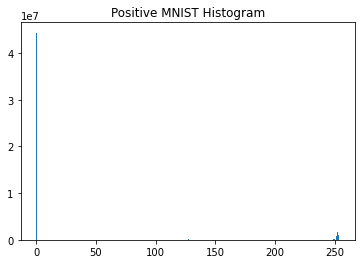

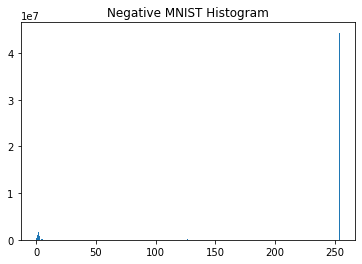

In [100]:
count, neg_count = compute_stats()

In [98]:
np.sum(count), np.sum(neg_count)

(54508883.0, 54880000.0)

In [92]:
mnist_pos_inv_trans(mnist_test_dataset[0][0] )

tensor([[[-9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09],
         [-9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09],
         [-9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,
          -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09, -9.1821e-09,


In [93]:
mnist_neg_inv_trans(mnist_neg_test_dataset[0][0] )

tensor([[[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+

In [223]:
loader = torch.utils.data.DataLoader(mnist_test_dataset,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False)

# mean = 0.
# std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

In [224]:
mean /= len(mnist_test_dataset)+len(mnist_train_dataset)
std /= len(mnist_test_dataset)+len(mnist_train_dataset)

In [225]:
mean, std

(tensor([0.1309]), tensor([0.3018]))

In [102]:
import json

In [103]:
data = json.load(open('/home/adityan/Studies/EE569_Spring2021/HW5/results/data.json','r'))

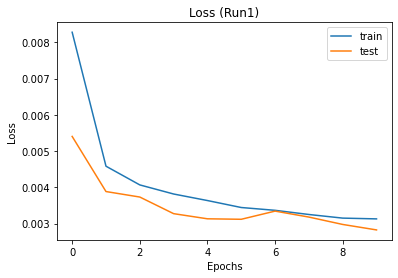

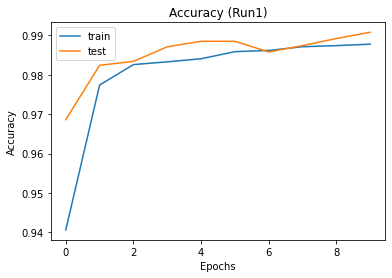

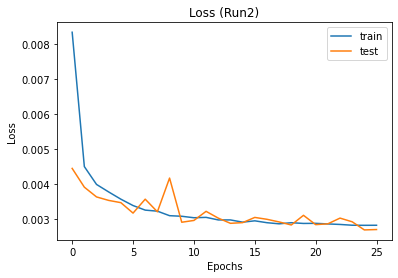

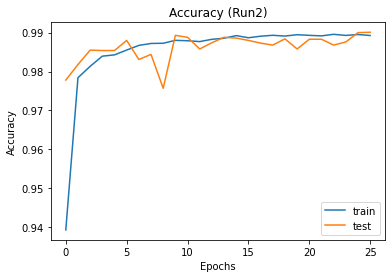

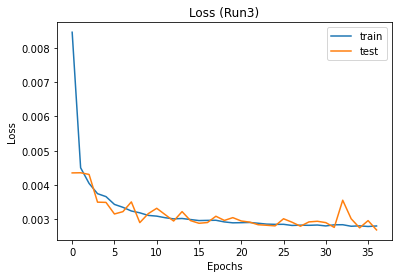

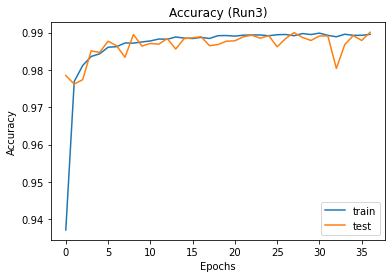

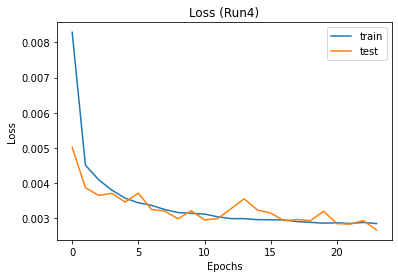

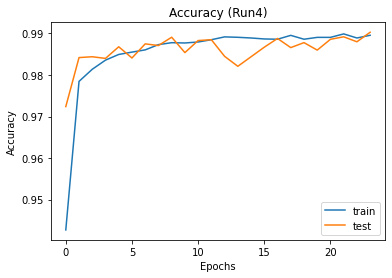

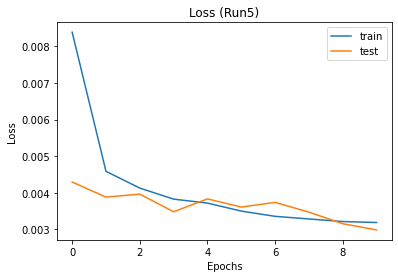

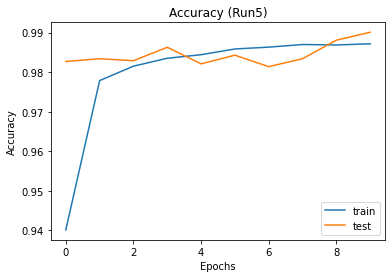

In [164]:
running_train_max_acc = []
running_train_min_loss = []
running_test_max_acc = []
running_test_min_loss = []
for i in range(5):
    data['mnist'][i]
    train_loss, train_acc, test_loss, test_acc = data['mnist'][i]
    running_train_max_acc += [train_acc[np.argmax(test_acc)]]
    running_train_min_loss += [train_loss[np.argmax(test_acc)]]
    running_test_max_acc += [test_acc[np.argmax(test_acc)]]
    running_test_min_loss += [test_loss[np.argmax(test_acc)]]
    plt.figure()
    plt.plot(train_loss, label='train')
    plt.plot(test_loss, label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss (Run{i+1})')
    plt.legend()
    plt.savefig(f'mnist_train_loss_config1_run{i+1}.png')
    plt.figure()
    plt.plot(train_acc, label='train')
    plt.plot(test_acc, label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy (Run{i+1})')
    plt.legend()
    plt.savefig(f'mnist_train_acc_config1_run{i+1}.png')

In [154]:
np.std(running_train_min_loss)

0.0006996967150419897

Config 2
{'mean_train_loss': 0.002478345422267914, 'mean_train_acc': 0.602012, 'mean_test_loss': 0.0026135067653656, 'mean_test_acc': 0.59068, 'std_train_loss': 3.0328070668586256e-05, 'std_train_acc': 0.0063801893388832735, 'std_test_loss': 1.784660088846153e-05, 'std_test_acc': 0.006232623845540487}
[0.0018689435112476348] [0.69346] [0.002134901225566864] [0.6519]
Config 3
{'mean_train_loss': 0.001944065386533737, 'mean_train_acc': 0.678724, 'mean_test_loss': 0.0021704989457130433, 'mean_test_acc': 0.6447, 'std_train_loss': 0.0001011538141695151, 'std_train_acc': 0.02015186105549558, 'std_test_loss': 5.8874431048490845e-05, 'std_test_acc': 0.01119374825516459}


/home/adityan/.conda/envs/reorder/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Config 4
{'mean_train_loss': 0.0038667850608825687, 'mean_train_acc': 0.43631600000000004, 'mean_test_loss': 0.003952594027519226, 'mean_test_acc': 0.43088, 'std_train_loss': 0.0003093929338778468, 'std_train_acc': 0.04825632128540259, 'std_test_loss': 0.0003038399843939842, 'std_test_acc': 0.04587781163046032}
Config 5
{'mean_train_loss': 0.0019594108097553253, 'mean_train_acc': 0.672604, 'mean_test_loss': 0.0022078374707698825, 'mean_test_acc': 0.63994, 'std_train_loss': 0.00012055968886852347, 'std_train_acc': 0.023780780138590904, 'std_test_loss': 6.390662335562881e-05, 'std_test_acc': 0.01554999678456556}


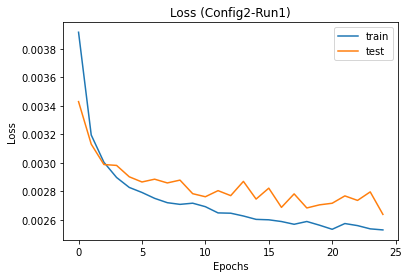

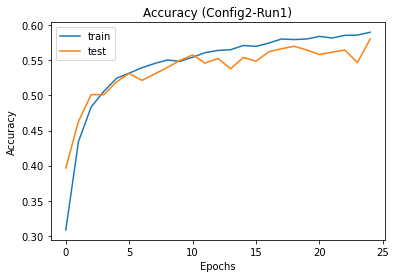

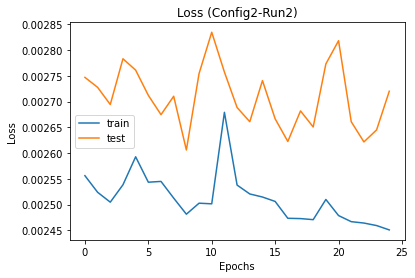

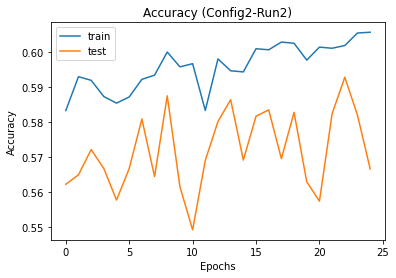

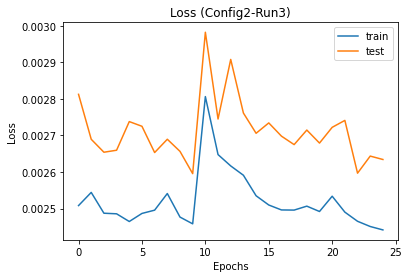

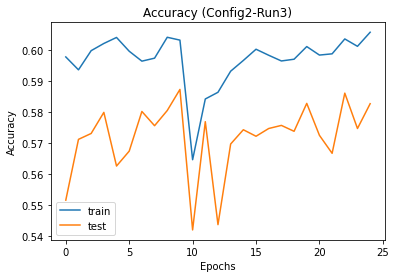

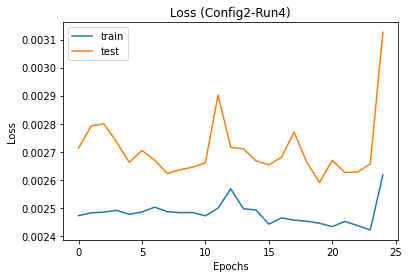

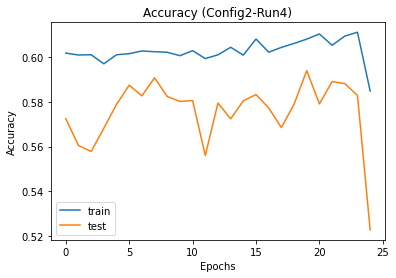

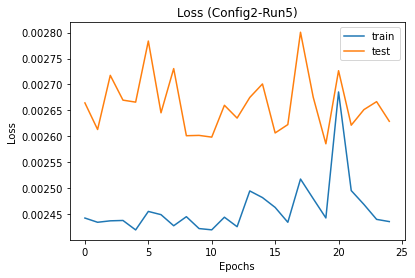

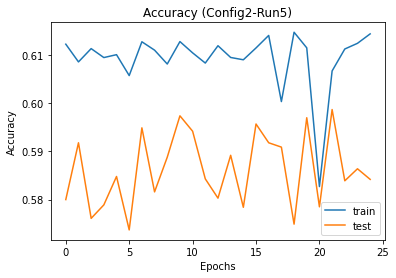

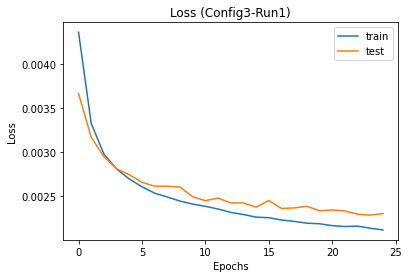

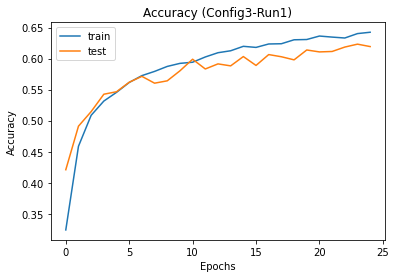

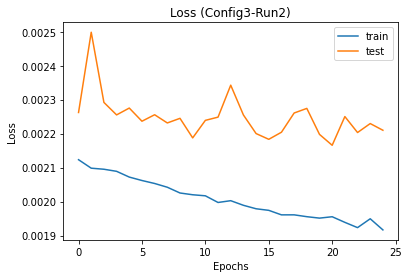

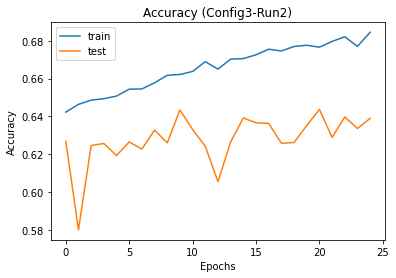

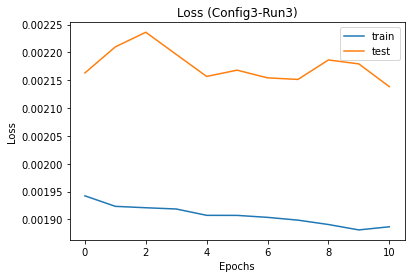

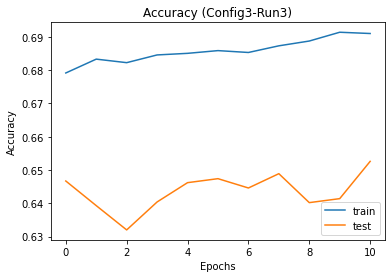

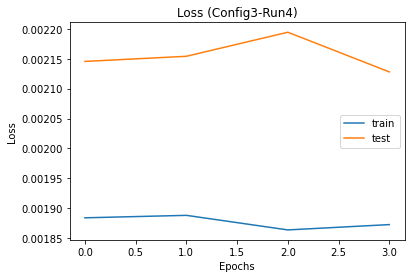

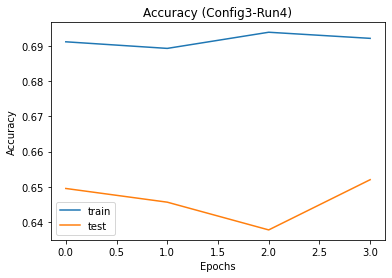

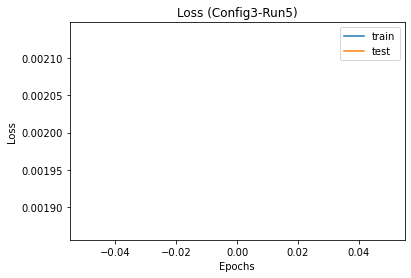

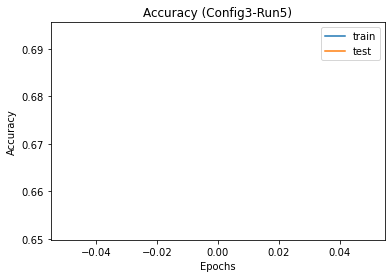

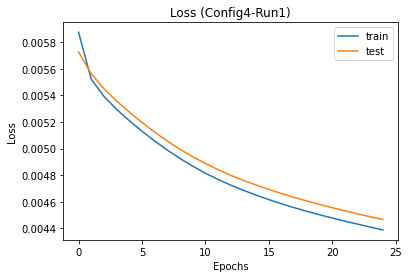

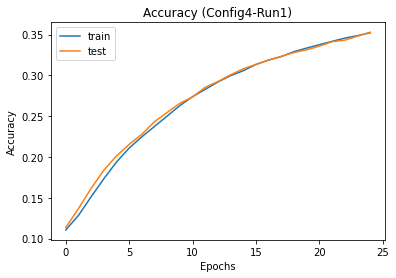

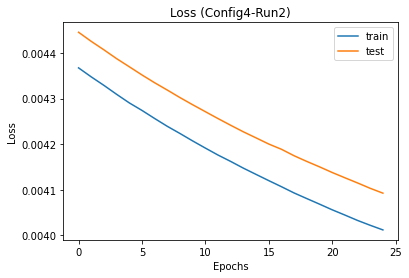

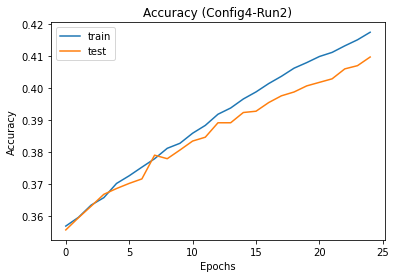

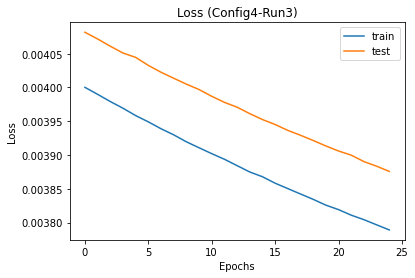

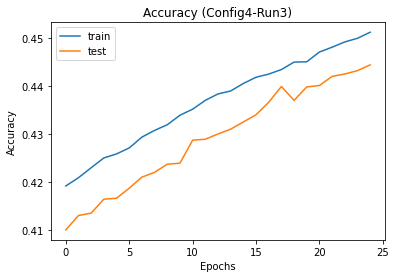

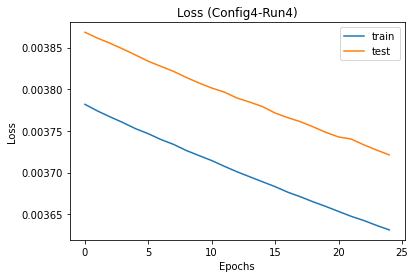

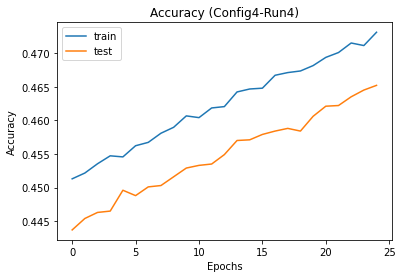

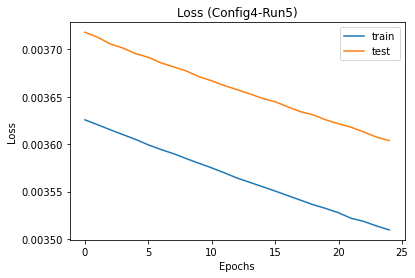

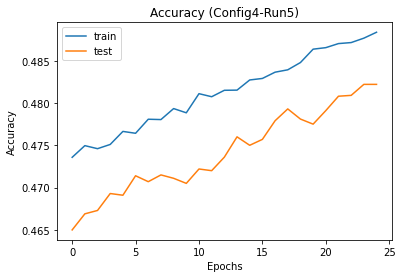

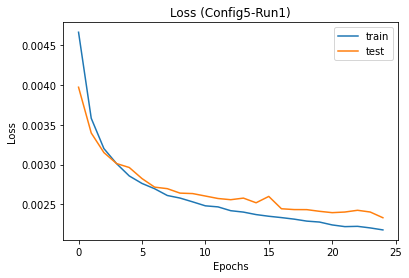

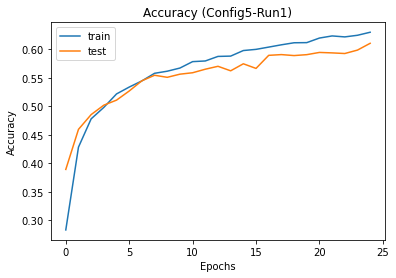

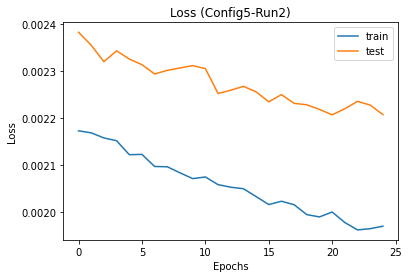

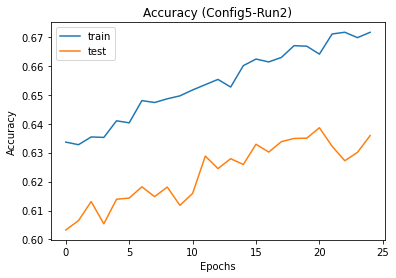

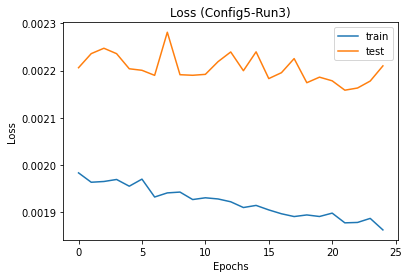

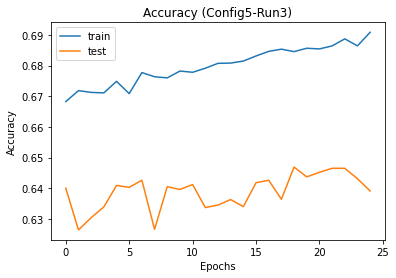

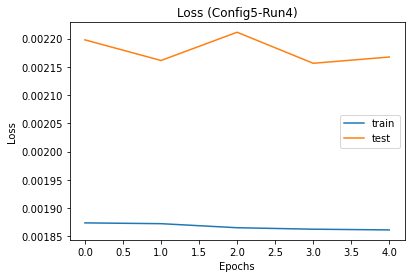

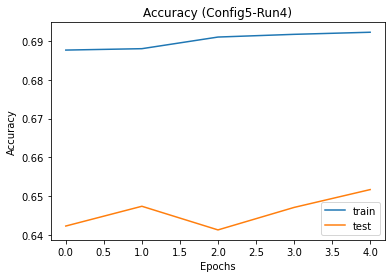

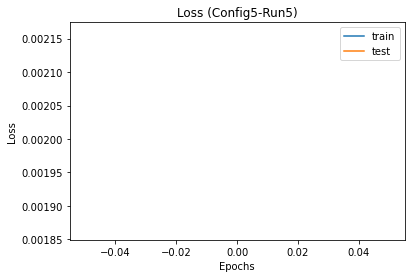

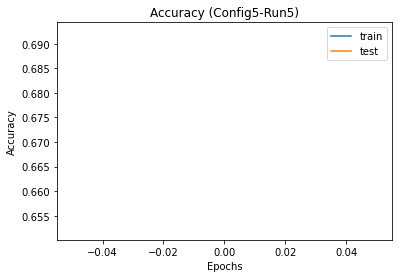

In [178]:
for i in range(2,6):
    data = json.load(open(f'/home/adityan/Studies/EE569_Spring2021/HW5/results/cifar_config{i}.json','r'))
    running_train_max_acc = []
    running_train_min_loss = []
    running_test_max_acc = []
    running_test_min_loss = []
    for j in range(5):
        train_loss, train_acc, test_loss, test_acc = data[f'config{j+1}']
        running_train_max_acc += [train_acc[np.argmax(test_acc)]]
        running_train_min_loss += [train_loss[np.argmax(test_acc)]]
        running_test_max_acc += [test_acc[np.argmax(test_acc)]]
        running_test_min_loss += [test_loss[np.argmax(test_acc)]]
        plt.figure()
        plt.plot(train_loss, label='train')
        plt.plot(test_loss, label='test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss (Config{i}-Run{j+1})')
        plt.legend()
        plt.savefig(f'cifar_loss_config{i}_run{j+1}.png')
        plt.figure()
        plt.plot(train_acc, label='train')
        plt.plot(test_acc, label='test')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy (Config{i}-Run{j+1})')
        plt.legend()
        plt.savefig(f'cifar_train_acc_config{i}_run{j+1}.png')
        if i == 3 and j+1 == 5:
            print(train_loss, train_acc, test_loss, test_acc)
            break
    print(f'Config {i}')
    print({
        'mean_train_loss': np.mean(running_train_min_loss),
        'mean_train_acc': np.mean(running_train_max_acc),
        'mean_test_loss': np.mean(running_test_min_loss),
        'mean_test_acc': np.mean(running_test_max_acc),
        'std_train_loss': np.std(running_train_min_loss),
        'std_train_acc': np.std(running_train_max_acc),
        'std_test_loss': np.std(running_test_min_loss),
        'std_test_acc': np.std(running_test_max_acc),
        
    })
    print('========')

In [171]:
for i in range(2,5):
    print(i)

2
3
4


In [182]:
data = json.load(open(f'/home/adityan/Studies/EE569_Spring2021/HW5/results/cifar_config3.json','r'))

In [183]:
data['config5']

[[0.0018689435112476348], [0.69346], [0.002134901225566864], [0.6519]]

In [181]:
i

5

In [240]:
data = json.load(open('/home/adityan/Studies/EE569_Spring2021/HW5/lenet.json','r'))

In [241]:
train_loss, train_acc, test_loss, test_acc = data[f'lenet']
running_train_max_acc = [train_acc[np.argmax(test_acc)]]
running_train_min_loss = [train_loss[np.argmax(test_acc)]]
running_test_max_acc = [test_acc[np.argmax(test_acc)]]
running_test_min_loss = [test_loss[np.argmax(test_acc)]]
# plt.figure()
# plt.plot(train_loss, label='train')
# plt.plot(test_loss, label='test')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title(f'Loss')
# plt.legend()
# plt.savefig(f'custom_classifier_loss.png')
# plt.figure()
# plt.plot(train_acc, label='train')
# plt.plot(test_acc, label='test')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title(f'Accuracy')
# plt.legend()
# plt.savefig(f'custom_classifier_train_acc.png')

In [242]:
running_test_max_acc

[0.2601]